(From Alia) First version of making all the vps for the a and b for the poster, again does concatenation. USE THE ONE WITH THE (1).

# Setup

In [1]:
import pandas as pd  # Data handling
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
from pyvbmc import VariationalPosterior
from pyvbmc.priors import SplineTrapezoidal
from scipy.optimize import minimize
import scipy.stats as scs
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
# import sys
# min = -sys.float_info.max


def derivs(t,curr_vals,a,b):
    x,xd = curr_vals
    xdd = -x - np.sign(x) * a * np.abs(x)**b
    return  xd,xdd

# time array for solution
tmax = 10
dt = 0.05
t = np.arange(0,tmax,dt)

# Range of values that parameters can take on
a_min = 0.0
a_max = 0.5
b_min = 1.0
b_max = 5.0

# Number of parameters (dimension)
D = 2

# Bounds for VBMC object (LB and UB expanded a bit beyond what the actual true values could be)
LB = np.full((1, D), a_min)
LB[0][0] = a_min
LB[0][1] = b_min - 1
UB = np.full((1, D), a_max)
UB[0][0] = a_max + 0.1
UB[0][1] = b_max + 1
PLB = np.copy(LB)
PLB[0][0] = a_min + 0.01
PLB[0][1] = b_min
PUB = np.copy(UB)
PUB[0][0] = a_max 
PUB[0][1] = b_max

# pick a random starting point and do initial minimizatio on it
np.random.seed(4) # leave this
x0_rand = np.random.uniform(PLB, PUB)

#set up prior
prior = SplineTrapezoidal(LB, PLB, PUB, UB)
options = {
    "display": "off"
}

vbmc_count = 0 

print("LB:",LB,"PLB:",PLB,"PUB:",PUB,"UB:",UB,'x0_rand:',x0_rand)

def log_likelihood(theta):
    a,b = theta
    #a = np.exp(a)
    sols = []
    for initial_condition in initial_conditions:
        sol = solve_ivp(derivs,(0,tmax),initial_condition,t_eval = t, args = (a,b), method = "LSODA").y
        sols.append(sol[0])
    big_sol = np.concatenate(sols)
    sliced_sol = big_sol[0::4]
    LL =  np.sum(-(0.5/sigma**2) * (y_true - sliced_sol)**2) #+ np.log(1/(sigma* (2*np.pi)**0.5))
    return LL
    

# pick some nice parameter values to investigate (nonlinear corners and a point in the middle)
a_vals = [0.06,0.06,0.5,0.5,0.28]
b_vals = [1.44,5.0,1.44,5.0,3.22]

initial_conditions = [[0.0, 3.5],[2.0, 0.0],[-0.5, -0.5],[3.14, -0.3]]

sigma = 0.1
noise_sigma = 0.05


LB: [[0. 0.]] PLB: [[0.01 1.  ]] PUB: [[0.5 5. ]] UB: [[0.6 6. ]] x0_rand: [[0.48384462 3.188929  ]]


-22.759156744971534


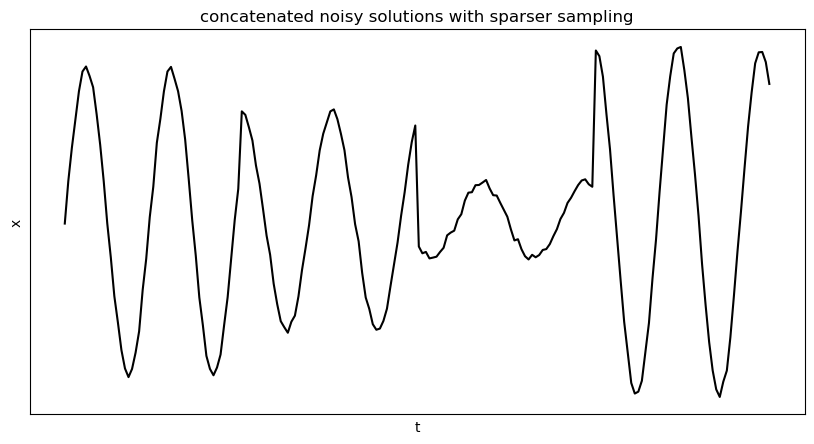

In [2]:
a = 0.3
b = 2.0
sols = []

for initial_condition in initial_conditions:
    sol = solve_ivp(derivs,(0,tmax),initial_condition,t_eval = t, args = (a,b),method = "LSODA").y
    sols.append(sol[0])
big_sol = np.concatenate(sols)
big_t = np.arange(0,4*tmax,dt ) #np.concatenate([t for i in range(4)])
sliced = big_sol[0::4]
noisy_sliced_sol = sliced + noise_sigma * np.random.randn(len(sliced))
y_true = noisy_sliced_sol
print(log_likelihood((a,b)))

plt.figure(figsize=(10,5))
plt.plot(noisy_sliced_sol, color = "black")
plt.title("concatenated noisy solutions with sparser sampling")
plt.xticks([])
plt.yticks([])
plt.grid()
plt.ylabel('x')
plt.xlabel('t')
plt.show()

In [3]:
# options2 = {
#     "display": "iter"
# }

# x0 = np.array([0.301,2.01])
# vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options2)
# vp, results = vbmc.optimize()

In [4]:
log_likelihood((0.3,2.))

-22.759156744971534

In [5]:
a_vals = np.linspace(0.1,0.5,4)
b_vals = np.linspace(1.1,1.5,4)
print(a_vals)
print(b_vals)

[0.1        0.23333333 0.36666667 0.5       ]
[1.1        1.23333333 1.36666667 1.5       ]


# Running and saving

In [6]:
seeds = np.arange(4)
count = 0
for seed in seeds:
    
    for i,a in enumerate(a_vals):

        for j,b in enumerate(b_vals):
            sols = []
            for initial_condition in initial_conditions:
                sol = solve_ivp(derivs,(0,tmax),initial_condition,t_eval = t, args = (a,b),method = "LSODA").y
                sols.append(sol[0])
            big_sol = np.concatenate(sols)
            sliced = big_sol[0::4]
            np.random.seed(seed)
            noisy_sliced_sol = sliced + noise_sigma * np.random.randn(len(sliced))
            y_true = noisy_sliced_sol
            np.random.seed(seed)
            count += 1
            np.random.seed(seed)
            x0 = np.random.uniform(PLB, PUB)
            np.random.seed(seed)
            vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options)
            np.random.seed(seed)
            vp, results = vbmc.optimize()
            vp.save("vp" + str(i) + "_" +  str(j) + "_" + str(seed) + ".hdf5", overwrite=True)
print(count)

Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -34.287 +/-0.011.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -34.223 +/-0.015.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -34.508 +/-0.031.
Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -34.772 +/-0.010.
Caution: Returned variational solution may have not converged.
Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -30.819 +/-0.407.
Caution: Returned variational solution may have not converged.
Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -563.506 +/-0.602.
Caution: Returned variational solution may have not converged.
Inference terminated: reached maximum numb

/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/cma/evolution_strategy.py:3823: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range = max(es.fit.fit) - min(es.fit.fit)
/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -2125.891 +/-102.567.
Caution: Returned variational solution may have not converged.
Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -6506.799 +/-5.781.
Caution: Returned variational solution may have not converged.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -29.613 +/-0.011.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -29.698 +/-0.014.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -29.860 +/-0.020.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -30.187 +/-0.013.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
